<a href="https://colab.research.google.com/github/sophiadt/robot-waiter-AI/blob/main/Robotics_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

We will be using GPU runtime with a CUDA backend. Let's change the runtime.

**Runtime ⟶ Change runtime type ⟶ Hardware accelerator: GPU ⟶ Save**

First we will install the libraries and download the datasets. This may take a few minutes.

In [ ]:
# install packages
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev 
!pip3 install dlib
!pip3 install face_recognition

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     |████████████████████████████████| 100.1 MB 6.5 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=0f8069d3940158340d4e9049b9e68d02c43db294e020772885c8aefd08258e85
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
!rm -r ./sample_data/
!gdown --id 1IsYNzt2CRM3RhZ9EEipOYpdPRTHwBXY6
!unzip project.zip
!rm project.zip

Downloading...
From: https://drive.google.com/uc?id=1IsYNzt2CRM3RhZ9EEipOYpdPRTHwBXY6
To: /content/project.zip
100% 800k/800k [00:00<00:00, 53.4MB/s]
Archive:  project.zip
   creating: customers/
   creating: customers/1/
  inflating: customers/1/1.jpg       
   creating: customers/0/
  inflating: customers/0/2.jpg       
   creating: customers/3/
  inflating: customers/3/3.jpg       
   creating: customers/4/
  inflating: customers/4/4.jpg       
   creating: customers/2/
  inflating: customers/2/5.jpg       
   creating: floorplan/
  inflating: floorplan/restaurant_1.png  
   creating: orders/
  inflating: orders/rey.jpg          


In [ ]:
# import libraries
import os

import numpy as np
from skimage.feature import hog
from skimage import data, exposure
import face_recognition

from PIL import Image, ImageEnhance, ImageDraw
import IPython.display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

font_config = {'size': 16}
fig_config = {'figsize': (12, 8)}
line_config = {'linewidth': 4}
plt.rc('font', **font_config)
plt.rc('figure', **fig_config)
plt.rc('lines', **line_config)

rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)

# Read images and setup environment

The folder structure is as follows:

```
├── customers
│   ├── 1
│   ├── ├── <somename>.jpg
│   ├── 2
│   ├── ├── <somename>.jpg
│   ├── ...
├── orders/
│   ├── <somename1>.jpg
│   └── <somename2>.jpg
└── floorplan/
│   ├── <floor>.jpg
```
We have added one image per customer, one image for the customer who placed an order, and one floorplan image. You can follow the training example from the lesson and add more images per person, and add multiple orders. The sample floorplan is a 32x32 image where the black colored cells represent obstacles.

We will randomly generate robot location and location of each customer in the walkable area.



Found 5 customers. (32, 32)
Robot position is [18  8]
Customer 1 is at [26 17]
Customer 4 is at [13 19]
Customer 2 is at [ 2 17]
Customer 0 is at [10  8]
Customer 3 is at [14 24]


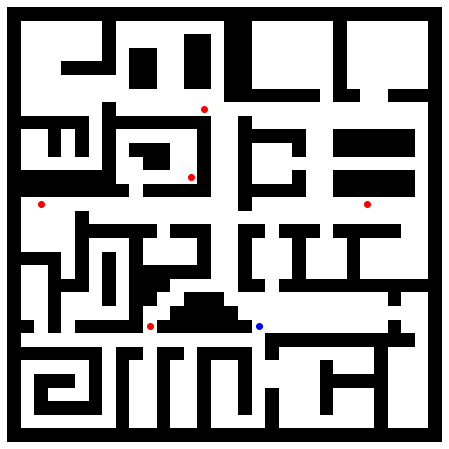

In [ ]:
# np.random.seed(0)     # seed random generator if you want to reproduce the results

floorplan = plt.imread('floorplan/restaurant_1.png')[:, :, 0]
customers = [c for c in os.listdir('customers/') if not c.startswith('.')]
print(f"Found {len(customers)} customers.", floorplan.shape)

# find white cells and obstacles in floorplan
free_space = np.asarray(np.where(floorplan == 1)).T
obstacles = np.asarray(np.where(floorplan == 0)).T

#select random positions for robot and customers
idx_robot = np.random.choice(len(free_space))
position_robot = free_space[idx_robot]
print(f"Robot position is {position_robot}")

idx_customer = np.random.choice(len(free_space), len(customers))
position_customers = free_space[idx_customer]
for i, customer in enumerate(customers):
  print(f"Customer {customer} is at {position_customers[i]}")

plt.figure()
figure_bounds = np.asarray([0, floorplan.shape[0], 0, floorplan.shape[1]]) -0.5   # (x,y) is the center of cell
plt.imshow(np.flipud(floorplan.T), extent=figure_bounds, cmap='Greys_r')          # images and matrixes are indexed differently. Use this to plot floorplan image.
plt.scatter(position_robot[0], position_robot[1], c='b')
plt.scatter(position_customers[:, 0], position_customers[:, 1], c='r')
plt.show()

For each order identify which customer has placed the order.

In [ ]:
# Write code to train and predict face recognition
# Hint: get relevant code from the lesson
import math
import os
import os.path
import pickle

from sklearn import neighbors
from face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

In [ ]:
def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    '''
    :param train_dir: directory that contains a sub-directory for each known person, with its name.
     (View in source code to see train_dir example tree structure)
     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...
    :param model_save_path: (optional) path to save model on disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
     '''
    X = []
    y = []

    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf

In [ ]:
def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):
    """
    Recognizes faces in given image using a trained KNN classifier
    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """
    
    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=2)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]


In [ ]:
def show_prediction_labels_on_image(img_path, predictions):
    """
    :param img_path: path to image to be recognized
    :param predictions: results of the predict function
    :return:
    """
    pil_image = plt.imread(img_path)
    fig,ax = plt.subplots(1)
    ax.imshow(pil_image)
    
    for name, (top, right, bottom, left) in predictions:
        # Draw a box around the face using the Pillow module
        color = tuple(np.random.rand(3))
        ax.add_patch(patches.Rectangle((left, top), right-left, bottom-top, fill=False, color=color)) 
        # Add the name under the face bounding box
        ax.text(left, bottom, name,  horizontalalignment='left', verticalalignment='top',
                bbox={'facecolor':color,'alpha':0.4, 'pad':1})
    plt.show()

In [ ]:
# STEP 1: Train the KNN classifier and save it to disk
# Once the model is trained and saved, you can skip this step next time.
print("Training KNN classifier...")
if not os.path.exists('out'):
      os.makedirs("out")
classifier = train("customers", model_save_path="out/trained_knn_model.clf", n_neighbors=1)
print("Training complete!")

# STEP 2: Using the trained classifier, make predictions for unknown image. (We only have one image)
image_file = [f for f in os.listdir("orders") if f.endswith('.jpg')][0]
full_file_path = os.path.join("orders", image_file)

print("Looking for faces in {}".format(image_file))

# Find the person in the image using a trained classifier model
predictions = predict(full_file_path, model_path="out/trained_knn_model.clf")

# We only have one person in the image.
name, location = predictions[0]

print("Identified {} as customer {}".format(image_file.split('.')[0], name))
print("{} is at position {}".format(image_file.split('.')[0], position_customers[int(name)]))

Training KNN classifier...
Training complete!
Looking for faces in rey.jpg
Identified rey as customer 2
rey is at position [ 2 17]


Now use any Path planning algorithm with robot position as start node and customer position as end node

In [ ]:
class Env:
    def __init__(self):
        self.x_range = 32  # size of background
        self.y_range = 32
        self.motions = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                        (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.obs = self.obs_map()

    def update_obs(self, obs):
        self.obs = obs

    def obs_map(self):
        """
        Initialize obstacles' positions
        :return: map of obstacles
        """

        x = self.x_range
        y = self.y_range
        obs = set()

        obstacles = np.asarray(np.where(floorplan == 0)).T
        obs = set()
        for i in range(len(obstacles)):
          obs.add((obstacles[i, 0], obstacles[i, 1]))


        return obs

In [ ]:
import os
import sys
import matplotlib.pyplot as plt

class Plotting:
    def __init__(self, xI, xG):
        self.xI, self.xG = xI, xG
        self.env = Env()
        self.obs = self.env.obs_map()

    def update_obs(self, obs):
        self.obs = obs

    def animation(self, path, visited, name):
        self.plot_grid(name)
        self.plot_visited(visited)
        self.plot_path(path)
        plt.show()

    def animation_lrta(self, path, visited, name):
        self.plot_grid(name)
        cl = self.color_list_2()
        path_combine = []

        for k in range(len(path)):
            self.plot_visited(visited[k], cl[k])
            plt.pause(0.2)
            self.plot_path(path[k])
            path_combine += path[k]
            plt.pause(0.2)
        if self.xI in path_combine:
            path_combine.remove(self.xI)
        self.plot_path(path_combine)
        plt.show()

    def animation_ara_star(self, path, visited, name):
        self.plot_grid(name)
        cl_v, cl_p = self.color_list()

        for k in range(len(path)):
            self.plot_visited(visited[k], cl_v[k])
            self.plot_path(path[k], cl_p[k], True)
            plt.pause(0.5)

        plt.show()

    def animation_bi_astar(self, path, v_fore, v_back, name):
        self.plot_grid(name)
        self.plot_visited_bi(v_fore, v_back)
        self.plot_path(path)
        plt.show()

    def plot_grid(self, name):
        obs_x = [x[0] for x in self.obs]
        obs_y = [x[1] for x in self.obs]

        plt.plot(self.xI[0], self.xI[1], "bs")
        plt.plot(self.xG[0], self.xG[1], "gs")
        plt.plot(obs_x, obs_y, "sk")
        plt.title(name)
        plt.axis("equal")

    def plot_visited(self, visited, cl='gray'):
        if self.xI in visited:
            visited.remove(self.xI)

        if self.xG in visited:
            visited.remove(self.xG)

        count = 0

        for x in visited:
            count += 1
            plt.plot(x[0], x[1], color=cl, marker='o')
            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])

            if count < len(visited) / 3:
                length = 20
            elif count < len(visited) * 2 / 3:
                length = 30
            else:
                length = 40
            #
            # length = 15

            if count % length == 0:
                plt.pause(0.001)
        plt.pause(0.01)

    def plot_path(self, path, cl='r', flag=False):
        path_x = [path[i][0] for i in range(len(path))]
        path_y = [path[i][1] for i in range(len(path))]

        if not flag:
            plt.plot(path_x, path_y, linewidth='3', color='r')
        else:
            plt.plot(path_x, path_y, linewidth='3', color=cl)

        plt.plot(self.xI[0], self.xI[1], "bs")
        plt.plot(self.xG[0], self.xG[1], "gs")

        plt.pause(0.01)

    def plot_visited_bi(self, v_fore, v_back):
        if self.xI in v_fore:
            v_fore.remove(self.xI)

        if self.xG in v_back:
            v_back.remove(self.xG)

        len_fore, len_back = len(v_fore), len(v_back)

        for k in range(max(len_fore, len_back)):
            if k < len_fore:
                plt.plot(v_fore[k][0], v_fore[k][1], linewidth='3', color='gray', marker='o')
            if k < len_back:
                plt.plot(v_back[k][0], v_back[k][1], linewidth='3', color='cornflowerblue', marker='o')

            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])

            if k % 10 == 0:
                plt.pause(0.001)
        plt.pause(0.01)

    @staticmethod
    def color_list():
        cl_v = ['silver',
                'wheat',
                'lightskyblue',
                'royalblue',
                'slategray']
        cl_p = ['gray',
                'orange',
                'deepskyblue',
                'red',
                'm']
        return cl_v, cl_p

    @staticmethod
    def color_list_2():
        cl = ['silver',
              'steelblue',
              'dimgray',
              'cornflowerblue',
              'dodgerblue',
              'royalblue',
              'plum',
              'mediumslateblue',
              'mediumpurple',
              'blueviolet',
              ]
        return cl

(18, 8)
(17, 9)
(16, 10)
(15, 11)
(14, 11)
(13, 11)
(18, 9)
(12, 11)
(17, 10)
(16, 11)
(16, 11)
(15, 12)
(15, 12)
(17, 7)
(18, 10)
(16, 7)
(16, 12)
(15, 7)
(15, 13)
(12, 10)
(18, 7)
(14, 7)
(11, 10)
(11, 10)
(19, 9)
(19, 8)
(13, 7)
(18, 10)
(16, 13)
(16, 12)
(12, 7)
(15, 14)
(19, 10)
(11, 7)
(10, 8)
(11, 9)
(10, 9)
(16, 14)
(16, 13)
(10, 7)
(10, 9)
(13, 6)
(15, 15)
(18, 6)
(19, 11)
(18, 12)
(9, 7)
(14, 16)
(13, 16)
(12, 16)
(11, 16)
(10, 16)
(9, 16)
(8, 16)
(7, 16)
(6, 16)
(16, 15)
(16, 14)
(5, 17)
(4, 17)
(3, 17)
(2, 17)
Congrats! You've found the end!


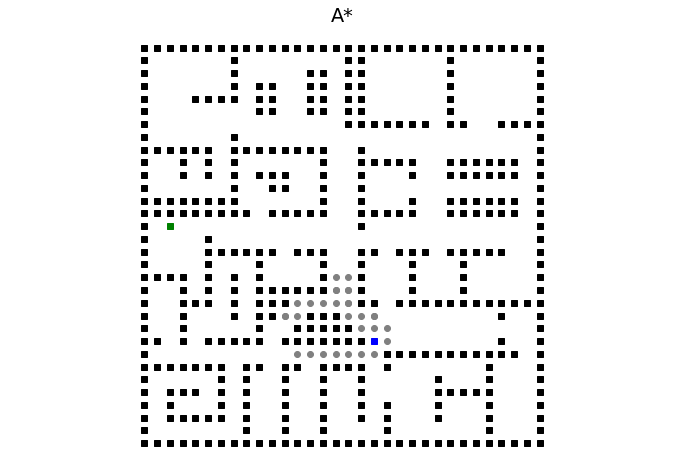

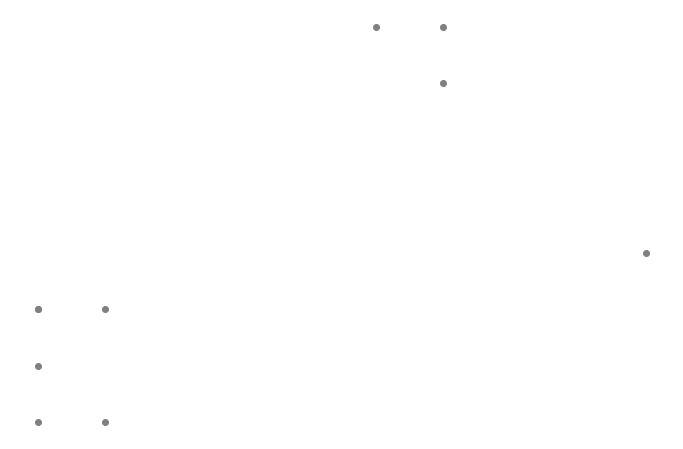

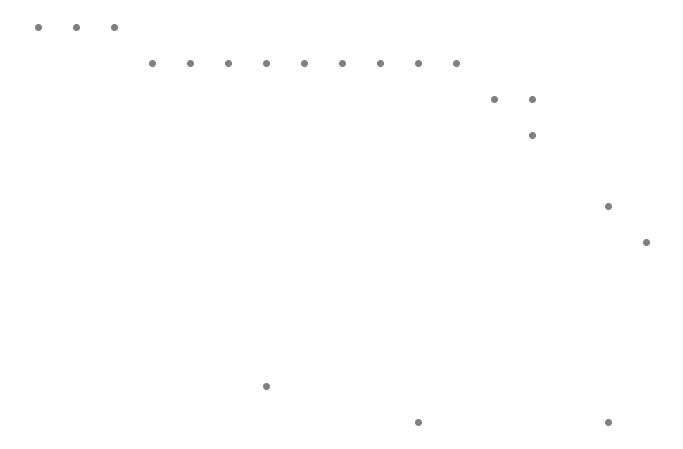

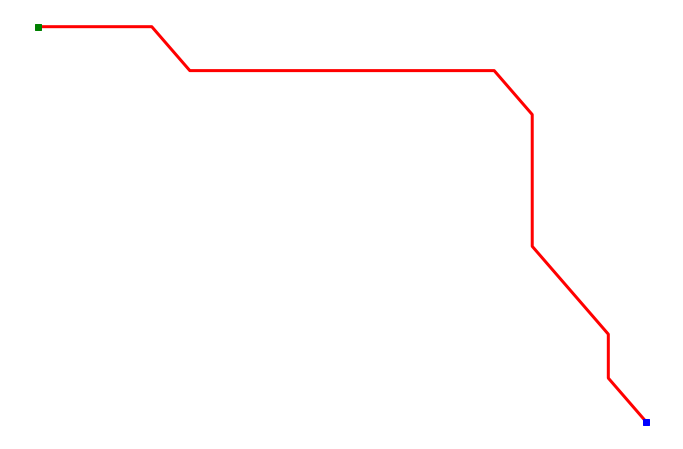

(18, 8)
(17, 9)
(16, 10)
(15, 11)
(14, 11)
(13, 11)
(18, 9)
(12, 11)
(17, 10)
(16, 11)
(16, 11)
(15, 12)
(15, 12)
(17, 7)
(18, 10)
(16, 7)
(16, 12)
(15, 7)
(15, 13)
(12, 10)
(18, 7)
(14, 7)
(11, 10)
(11, 10)
(19, 9)
(19, 8)
(13, 7)
(18, 10)
(16, 13)
(16, 12)
(12, 7)
(15, 14)
(19, 10)
(11, 7)
(10, 8)
(11, 9)
(10, 9)
(16, 14)
(16, 13)
(10, 7)
(10, 9)
(13, 6)
(15, 15)
(18, 6)
(19, 11)
(18, 12)
(9, 7)
(14, 16)
(13, 16)
(12, 16)
(11, 16)
(10, 16)
(9, 16)
(8, 16)
(7, 16)
(6, 16)
(16, 15)
(16, 14)
(5, 17)
(4, 17)
(3, 17)
(2, 17)
Congrats! You've found the end!


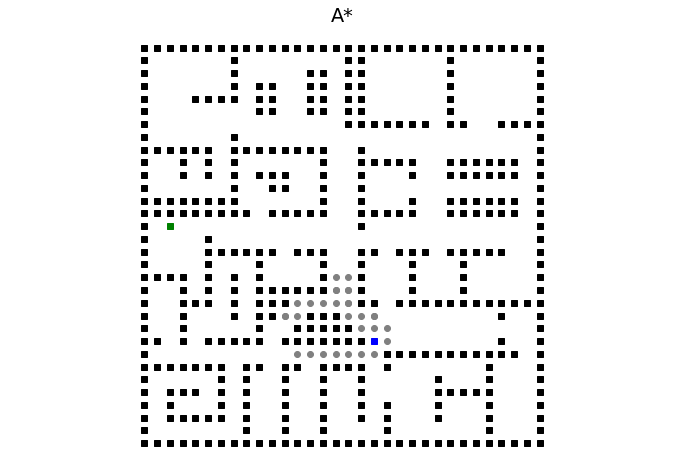

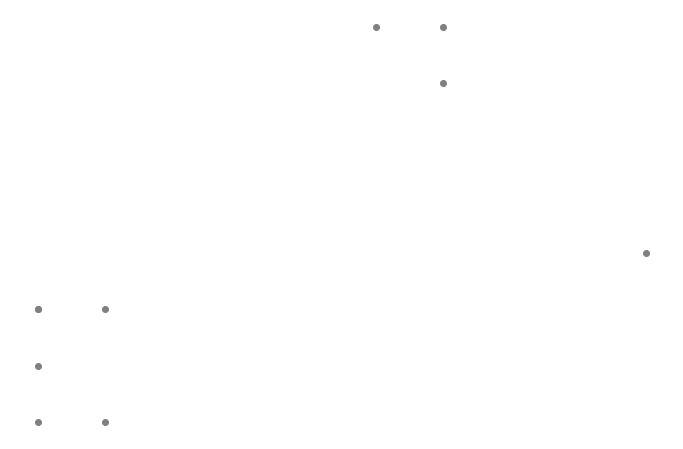

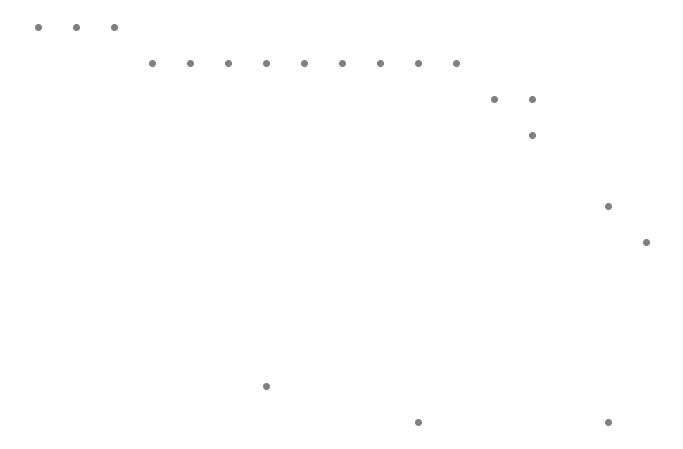

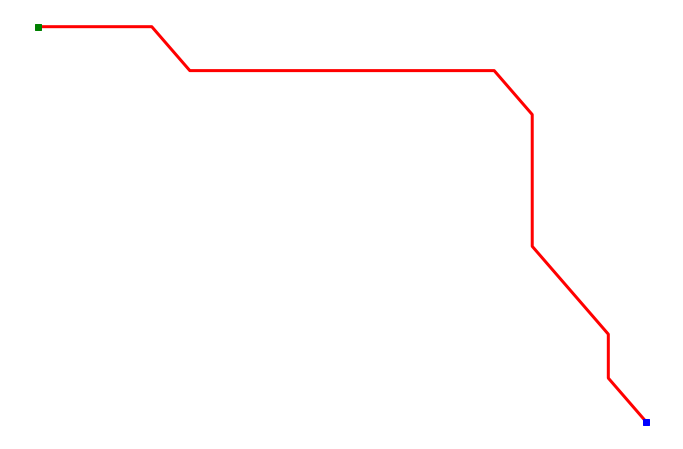

In [ ]:
# Write code here
"""
ITF 2021
Author: Pedram  Agand
pagand@sfu.ca
"""

import os
import sys
import math
import heapq

import matplotlib.pyplot as plt


class AStar:
    """AStar set the cost + heuristics as the priority
    """
    def __init__(self, s_start, s_goal, heuristic_type):
        self.s_start = s_start #inital position
        self.s_goal = s_goal #goal position 
        self.heuristic_type = heuristic_type 

        self.Env = Env()  # class Env

        self.u_set = self.Env.motions  # feasible input set, up down right left
        self.obs = self.Env.obs  # position of obstacles

        self.OPEN = []  # priority queue / OPEN set
        self.CLOSED = []  # CLOSED set / VISITED order
        self.PARENT = dict()  # recorded parent
        self.g = dict()  # cost to come

    def searching(self):
        """
        A_star Searching.
        :return: path, visited order
        """

        self.PARENT[self.s_start] = self.s_start
        self.g[self.s_start] = 0
        self.g[self.s_goal] = math.inf
        heapq.heappush(self.OPEN,
                       (self.f_value(self.s_start), self.s_start))

        while self.OPEN:
          _, s = heapq.heappop(self.OPEN)
          self.CLOSED.append(s)
          print(s)
          """ Edit 1:
          <put stop condition> """
          if s == self.s_goal: #s means current node, current position
            print("Congrats! You've found the end!")
            break

          for s_n in self.get_neighbor(s):
            """ Edit 2:
            <compute new_cost> """
            new_cost = self.g[s] + self.cost(s, s_n) #why were these the two parameters?
#current cost + cost from current to end 
            if s_n not in self.g:
                  self.g[s_n] = math.inf
#incorrect position
            if new_cost < self.g[s_n]: # conditions for updating Cost
              """ Edit 3:
              <update cost: g and PARENT elements> """
              self.g[s_n] = new_cost
              self.PARENT[s_n] = s
#less cost (better), closer to position ie. moving from est. 18-20(s)
              heapq.heappush(self.OPEN, (self.f_value(s_n), s_n))

        return self.extract_path(self.PARENT), self.CLOSED

    def searching_repeated_astar(self, e):
        """
        repeated A*.
        :param e: weight of A*
        :return: path and visited order
        """

        path, visited = [], []

        while e >= 1:
            p_k, v_k = self.repeated_searching(self.s_start, self.s_goal, e)
            path.append(p_k)
            visited.append(v_k)
            e -= 0.5

        return path, visited

    def repeated_searching(self, s_start, s_goal, e):
        """
        run A* with weight e.
        :param s_start: starting state
        :param s_goal: goal state
        :param e: weight of a*
        :return: path and visited order.
        """

        g = {s_start: 0, s_goal: float("inf")}
        PARENT = {s_start: s_start}
        OPEN = []
        CLOSED = []
        heapq.heappush(OPEN,
                       (g[s_start] + e * self.heuristic(s_start), s_start))

        while OPEN:
            _, s = heapq.heappop(OPEN)
            CLOSED.append(s)

            if s == s_goal:
                break

            for s_n in self.get_neighbor(s):
                new_cost = g[s] + self.cost(s, s_n)

                if s_n not in g:
                    g[s_n] = math.inf

                if new_cost < g[s_n]:  # conditions for updating Cost
                    g[s_n] = new_cost
                    PARENT[s_n] = s
                    heapq.heappush(OPEN, (g[s_n] + e * self.heuristic(s_n), s_n))

        return self.extract_path(PARENT), CLOSED

    def get_neighbor(self, s):
        """
        find neighbors of state s that not in obstacles.
        :param s: state
        :return: neighbors
        """

        """ Edit 4:
            <return list of state neighbors for all actions> """
        return [(s[0] + u[0], s[1] + u[1]) for u in self.u_set] 
      #current(s) + left/right/up/down
    def cost(self, s_start, s_goal):
        """
        Calculate Cost for this motion
        :param s_start: starting node
        :param s_goal: end node
        :return:  Cost for this motion
        :note: Cost function could be more complicated!
        """

        if self.is_collision(s_start, s_goal):
            return math.inf

        return math.hypot(s_goal[0] - s_start[0], s_goal[1] - s_start[1])

    def is_collision(self, s_start, s_end):
        """
        check if the line segment (s_start, s_end) is collision.
        :param s_start: start node
        :param s_end: end node
        :return: True: is collision / False: not collision
        """
        """Edit 5:
        <check if a collision happened with s_start and s_end> """
        if s_start in self.obs or s_end in self.obs:
          return True
        else: 
          return False
    
        if s_start[0] != s_end[0] and s_start[1] != s_end[1]:
            if s_end[0] - s_start[0] == s_start[1] - s_end[1]:
                s1 = (min(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
            else:
                s1 = (min(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
#
            if s1 in self.obs or s2 in self.obs:
                return True

        return False

    def f_value(self, s):
      """
      f = g + h. (g: Cost to come, h: heuristic value)
      :param s: current state
      :return: f
      """
      """ Edit 6:
      <return the f value given g and h> """
      return self.g[s] + self.heuristic(s)

    def extract_path(self, PARENT):
        """
        Extract the path based on the PARENT set.
        :return: The planning path
        """

        path = [self.s_goal]
        s = self.s_goal

        while True:
          """ Edit 7:
          <compute the path using PARENT> """
          s = PARENT[s]
          path.append(s)
          if s == self.s_start:
            break
        return list(path)

    def heuristic(self, s):
        """
        Calculate heuristic.
        :param s: current node (state)
        :return: heuristic function value
        """
        heuristic_type = self.heuristic_type  # heuristic type
        goal = self.s_goal  # goal node

        if heuristic_type == "manhattan":
          """ Edit 8:
          <return the manhattan distance given the goal and s> """
          return abs(goal[0] -s[0]) + abs(goal[1] - s[1])
            
        else:
          """ Edit 9:
          <return the eucleadian distance given the goal and s using math library> """
          return math.hypot(goal[0] - s[0], goal[1] - s[1])

def main():
    s_start = tuple(position_robot)
    s_goal = tuple(position_customers[int(name)])

    astar = AStar(s_start, s_goal, "euclidean")
    """ Edit 10:
    <instantiate the plotting class with the start and end point> """
    plot = Plotting(s_start, s_goal)

    path, visited = astar.searching()
    plot.animation(path, visited, "A*")  # animation
    return path
    #path, visited = astar.searching_repeated_astar(2.5)               # initial weight e = 2.5
    #plot.animation_ara_star(path, visited, "Repeated A*")


if __name__ == '__main__':
    main()
    path = main()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys

class Plotting:
    def __init__(self, x_start, x_goal):
        self.xI, self.xG = x_start, x_goal
        self.env = Env()
        self.obs_bound = self.env.obs_boundary
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle

    def animation(self, nodelist, path, name, animation=False):
        self.plot_grid(name)
        self.plot_visited(nodelist, animation)
        self.plot_path(path)

    def animation_connect(self, V1, V2, path, name):
        self.plot_grid(name)
        self.plot_visited_connect(V1, V2)
        self.plot_path(path)

    def plot_grid(self, name):
        fig, ax = plt.subplots()

        for (ox, oy, w, h) in self.obs_bound:
            ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='black',
                    fill=True
                )
            )

        for (ox, oy, w, h) in self.obs_rectangle:
            ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        for (ox, oy, r) in self.obs_circle:
            ax.add_patch(
                patches.Circle(
                    (ox, oy), r,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        plt.plot(self.xI[0], self.xI[1], "bs", linewidth=3)
        plt.plot(self.xG[0], self.xG[1], "gs", linewidth=3)

        plt.title(name)
        plt.axis("equal")

    @staticmethod
    def plot_visited(nodelist, animation):
        if animation:
            count = 0
            for node in nodelist:
                count += 1
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")
                    plt.gcf().canvas.mpl_connect('key_release_event',
                                                 lambda event:
                                                 [exit(0) if event.key == 'escape' else None])
                    if count % 10 == 0:
                        plt.pause(0.001)
        else:
            for node in nodelist:
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")

    @staticmethod
    def plot_visited_connect(V1, V2):
        len1, len2 = len(V1), len(V2)

        for k in range(max(len1, len2)):
            if k < len1:
                if V1[k].parent:
                    plt.plot([V1[k].x, V1[k].parent.x], [V1[k].y, V1[k].parent.y], "-g")
            if k < len2:
                if V2[k].parent:
                    plt.plot([V2[k].x, V2[k].parent.x], [V2[k].y, V2[k].parent.y], "-g")

            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])

            if k % 2 == 0:
                plt.pause(0.001)

        plt.pause(0.01)

    @staticmethod
    def plot_path(path):
        if len(path) != 0:
            plt.plot([x[0] for x in path], [x[1] for x in path], '-r', linewidth=2)
            plt.pause(0.01)
        plt.show()

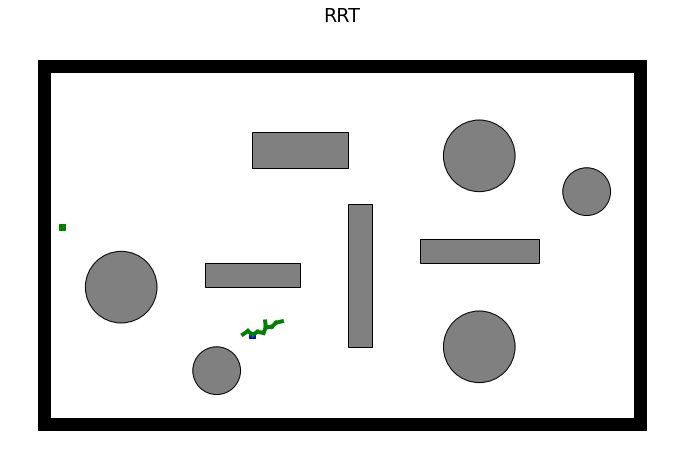

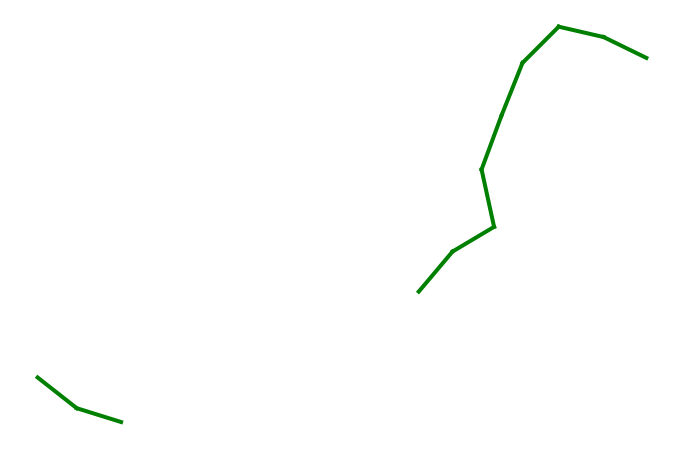

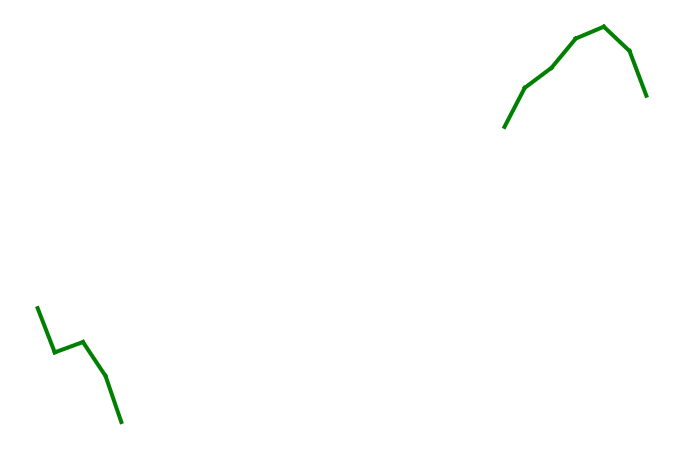

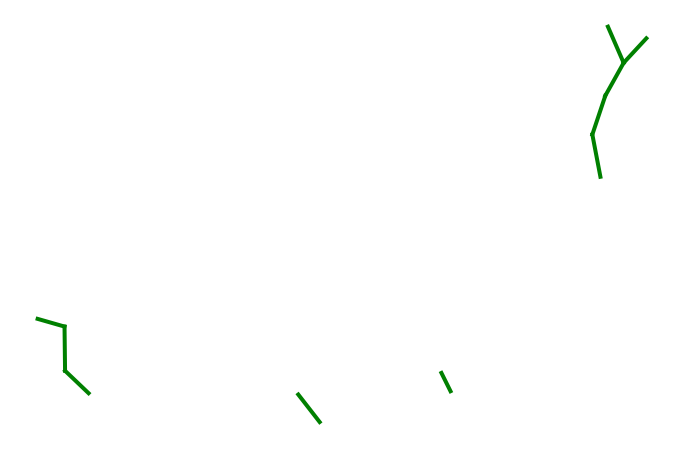

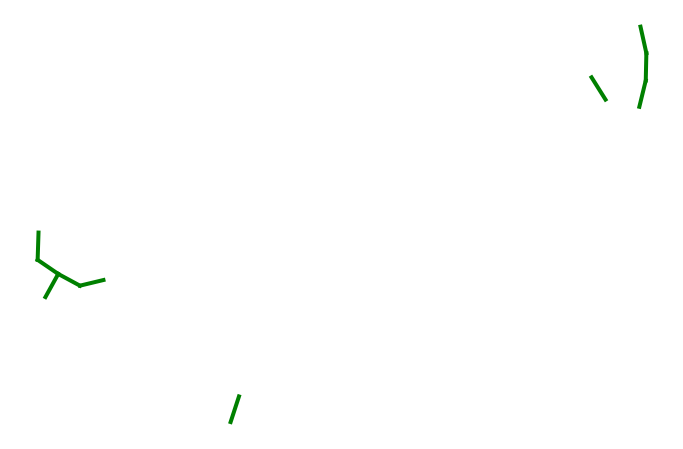

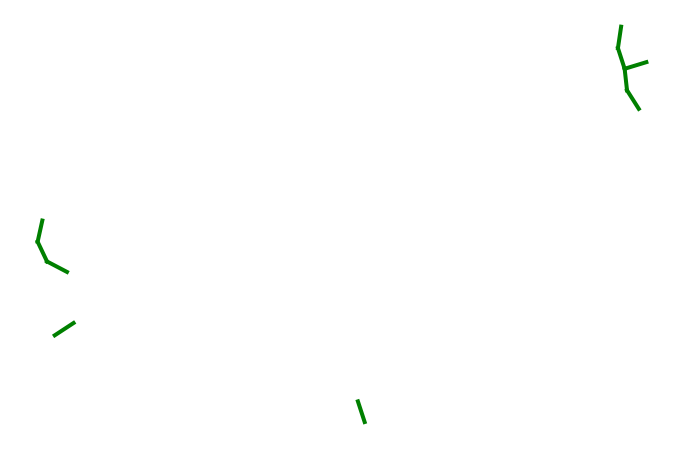

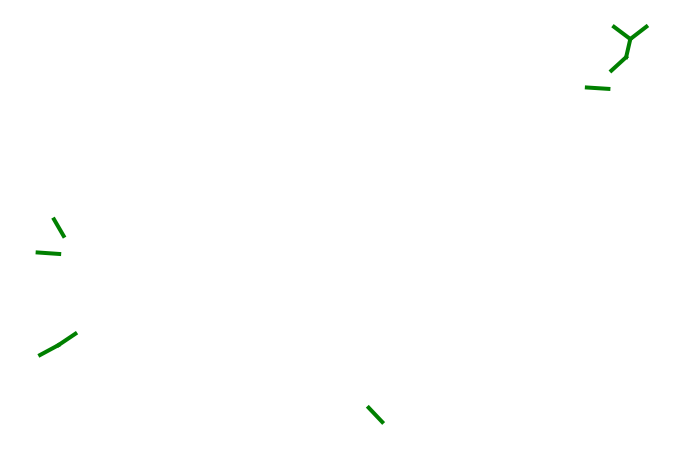

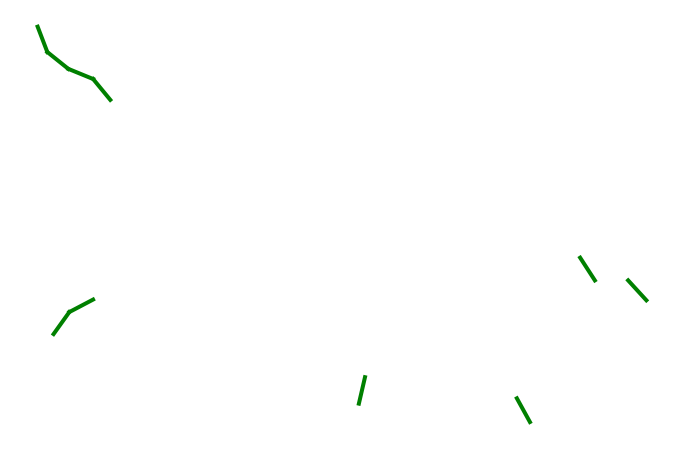

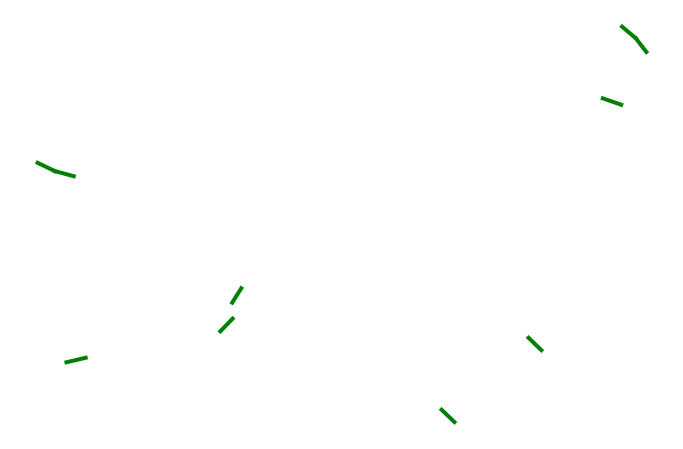

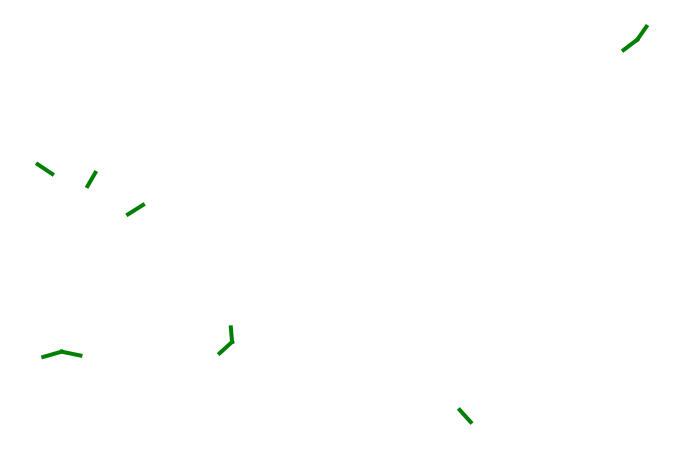

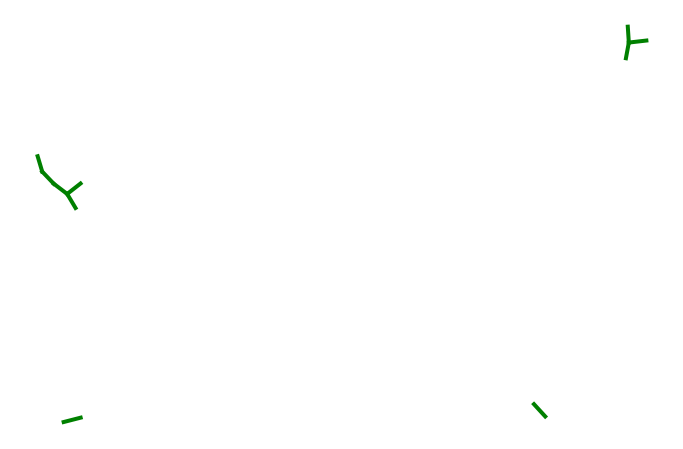

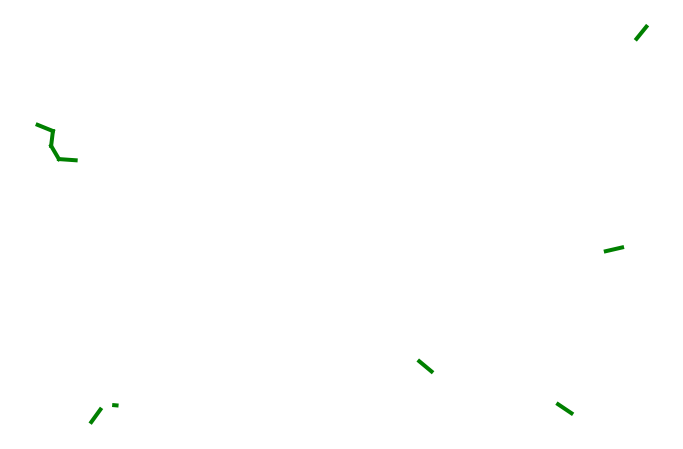

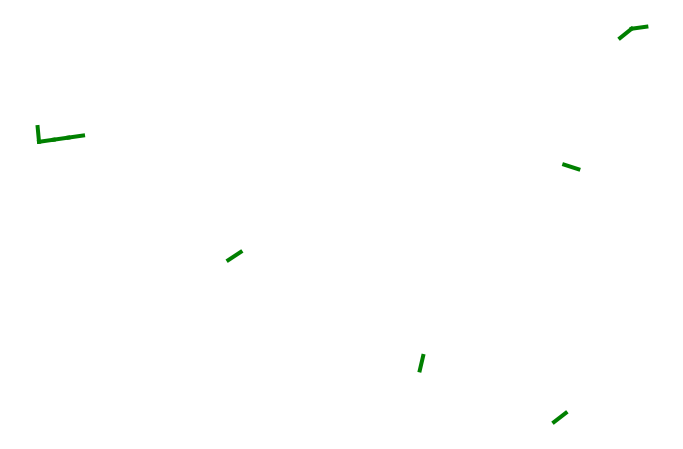

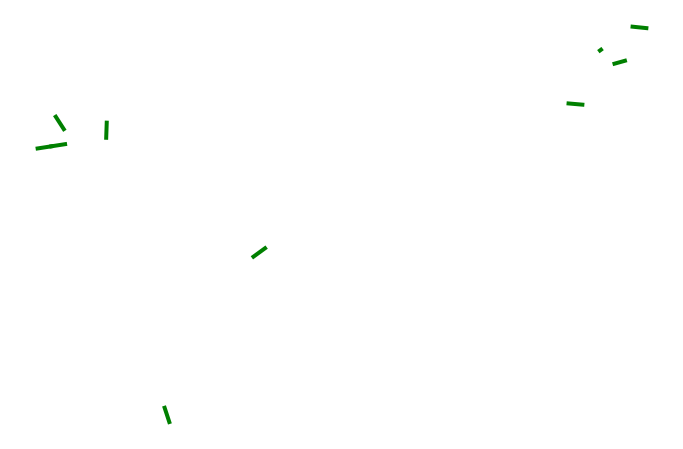

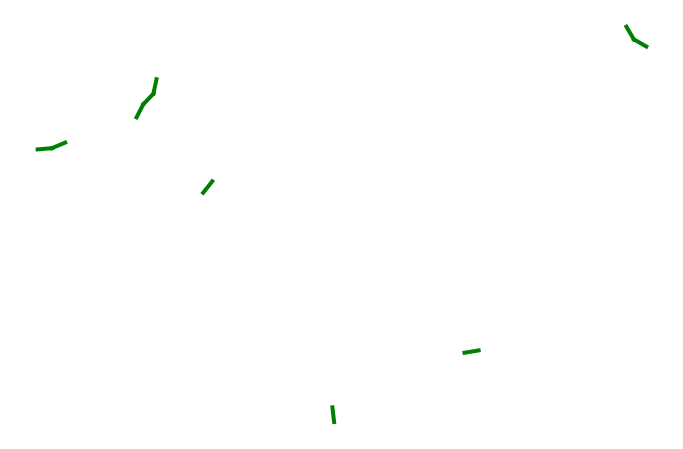

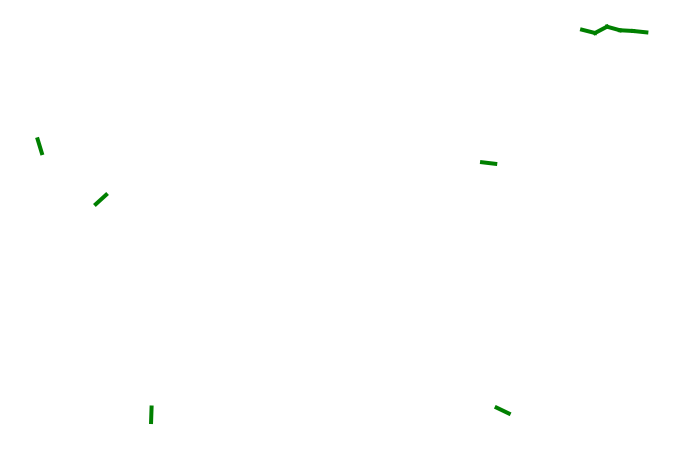

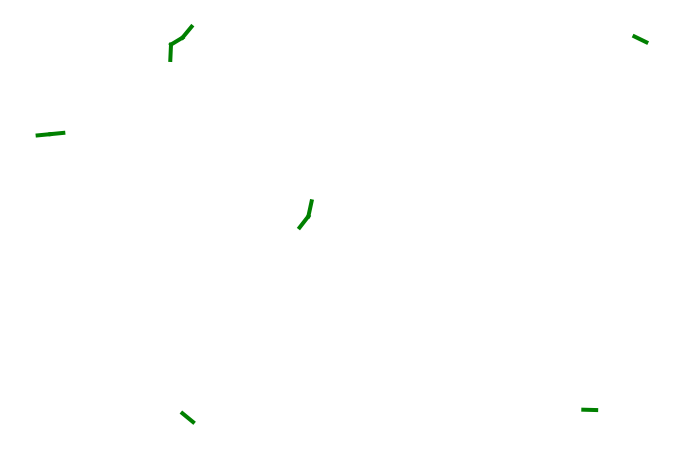

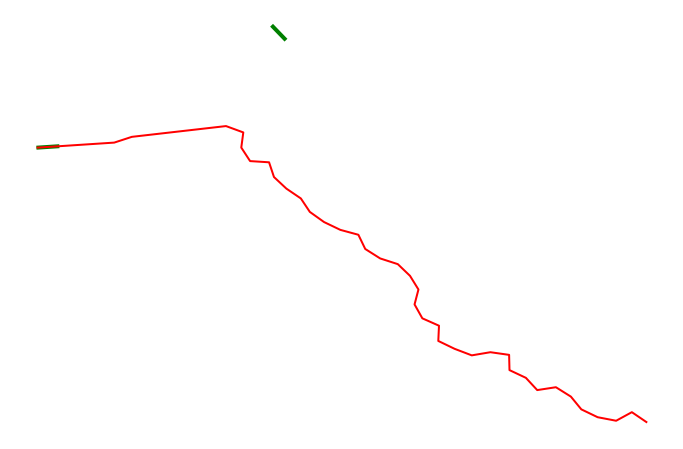

In [ ]:
import os
import sys
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches


#####
class Plotting:
    def __init__(self, x_start, x_goal):
        self.xI, self.xG = x_start, x_goal
        self.env = Env()
        self.obs_bound = self.env.obs_boundary
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle

    def animation(self, nodelist, path, name, animation=False):
        self.plot_grid(name)
        self.plot_visited(nodelist, animation)
        self.plot_path(path)

    def animation_connect(self, V1, V2, path, name):
        self.plot_grid(name)
        self.plot_visited_connect(V1, V2)
        self.plot_path(path)

    def plot_grid(self, name):
        fig, ax = plt.subplots()

        for (ox, oy, w, h) in self.obs_bound:
            ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='black',
                    fill=True
                )
            )

        for (ox, oy, w, h) in self.obs_rectangle:
            ax.add_patch(
                patches.Rectangle(
                    (ox, oy), w, h,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        for (ox, oy, r) in self.obs_circle:
            ax.add_patch(
                patches.Circle(
                    (ox, oy), r,
                    edgecolor='black',
                    facecolor='gray',
                    fill=True
                )
            )

        plt.plot(self.xI[0], self.xI[1], "bs", linewidth=3)
        plt.plot(self.xG[0], self.xG[1], "gs", linewidth=3)

        plt.title(name)
        plt.axis("equal")

    @staticmethod
    def plot_visited(nodelist, animation):
        if animation:
            count = 0
            for node in nodelist:
                count += 1
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")
                    plt.gcf().canvas.mpl_connect('key_release_event',
                                                 lambda event:
                                                 [exit(0) if event.key == 'escape' else None])
                    if count % 10 == 0:
                        plt.pause(0.001)
        else:
            for node in nodelist:
                if node.parent:
                    plt.plot([node.parent.x, node.x], [node.parent.y, node.y], "-g")

    @staticmethod
    def plot_visited_connect(V1, V2):
        len1, len2 = len(V1), len(V2)

        for k in range(max(len1, len2)):
            if k < len1:
                if V1[k].parent:
                    plt.plot([V1[k].x, V1[k].parent.x], [V1[k].y, V1[k].parent.y], "-g")
            if k < len2:
                if V2[k].parent:
                    plt.plot([V2[k].x, V2[k].parent.x], [V2[k].y, V2[k].parent.y], "-g")

            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])

            if k % 2 == 0:
                plt.pause(0.001)

        plt.pause(0.01)

    @staticmethod
    def plot_path(path):
        if len(path) != 0:
            plt.plot([x[0] for x in path], [x[1] for x in path], '-r', linewidth=2)
            plt.pause(0.01)
        plt.show()
#####

class Env:
    def __init__(self):
        self.x_range = (0, 50)
        self.y_range = (0, 30)
        self.obs_boundary = self.obs_boundary()
        self.obs_circle = self.obs_circle()
        self.obs_rectangle = self.obs_rectangle()

    @staticmethod
    def obs_boundary():
        obs_boundary = [
            [0, 0, 1, 30],
            [0, 30, 50, 1],
            [1, 0, 50, 1],
            [50, 1, 1, 30]
        ]
        return obs_boundary

    @staticmethod
    def obs_rectangle():
        obs_rectangle = [
            [14, 12, 8, 2],
            [18, 22, 8, 3],
            [26, 7, 2, 12],
            [32, 14, 10, 2]
        ]
        return obs_rectangle

    @staticmethod
    def obs_circle():
        obs_cir = [
            [7, 12, 3],
            [46, 20, 2],
            [15, 5, 2],
            [37, 7, 3],
            [37, 23, 3]
        ]

        return obs_cir

class Utils:
    def __init__(self):
        self.env = Env()

        self.delta = 0.5
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle
        self.obs_boundary = self.env.obs_boundary

    def update_obs(self, obs_cir, obs_bound, obs_rec):
        self.obs_circle = obs_cir
        self.obs_boundary = obs_bound
        self.obs_rectangle = obs_rec

    def get_obs_vertex(self):
        delta = self.delta
        obs_list = []

        for (ox, oy, w, h) in self.obs_rectangle:
            vertex_list = [[ox - delta, oy - delta],
                           [ox + w + delta, oy - delta],
                           [ox + w + delta, oy + h + delta],
                           [ox - delta, oy + h + delta]]
            obs_list.append(vertex_list)

        return obs_list

    def is_intersect_rec(self, start, end, o, d, a, b):
        v1 = [o[0] - a[0], o[1] - a[1]]
        v2 = [b[0] - a[0], b[1] - a[1]]
        v3 = [-d[1], d[0]]

        div = np.dot(v2, v3)

        if div == 0:
            return False

        t1 = np.linalg.norm(np.cross(v2, v1)) / div
        t2 = np.dot(v1, v3) / div

        if t1 >= 0 and 0 <= t2 <= 1:
            shot = Node((o[0] + t1 * d[0], o[1] + t1 * d[1]))
            dist_obs = self.get_dist(start, shot)
            dist_seg = self.get_dist(start, end)
            if dist_obs <= dist_seg:
                return True

        return False

    def is_intersect_circle(self, o, d, a, r):
        d2 = np.dot(d, d)
        delta = self.delta

        if d2 == 0:
            return False

        t = np.dot([a[0] - o[0], a[1] - o[1]], d) / d2

        if 0 <= t <= 1:
            shot = Node((o[0] + t * d[0], o[1] + t * d[1]))
            if self.get_dist(shot, Node(a)) <= r + delta:
                return True

        return False

    def is_collision(self, start, end):
        if self.is_inside_obs(start) or self.is_inside_obs(end):
            return True

        o, d = self.get_ray(start, end)
        obs_vertex = self.get_obs_vertex()

        for (v1, v2, v3, v4) in obs_vertex:
            if self.is_intersect_rec(start, end, o, d, v1, v2):
                return True
            if self.is_intersect_rec(start, end, o, d, v2, v3):
                return True
            if self.is_intersect_rec(start, end, o, d, v3, v4):
                return True
            if self.is_intersect_rec(start, end, o, d, v4, v1):
                return True

        for (x, y, r) in self.obs_circle:
            if self.is_intersect_circle(o, d, [x, y], r):
                return True

        return False

    def is_inside_obs(self, node):
        delta = self.delta

        for (x, y, r) in self.obs_circle:
            if math.hypot(node.x - x, node.y - y) <= r + delta:
                return True

        for (x, y, w, h) in self.obs_rectangle:
            if 0 <= node.x - (x - delta) <= w + 2 * delta \
                    and 0 <= node.y - (y - delta) <= h + 2 * delta:
                return True

        for (x, y, w, h) in self.obs_boundary:
            if 0 <= node.x - (x - delta) <= w + 2 * delta \
                    and 0 <= node.y - (y - delta) <= h + 2 * delta:
                return True

        return False

    @staticmethod
    def get_ray(start, end):
        orig = [start.x, start.y]
        direc = [end.x - start.x, end.y - start.y]
        return orig, direc

    @staticmethod
    def get_dist(start, end):
        return math.hypot(end.x - start.x, end.y - start.y)

class Node:
    def __init__(self, n):
        self.x = n[0]
        self.y = n[1]
        self.parent = None


class Rrt:
    def __init__(self, s_start, s_goal, step_len, goal_sample_rate, iter_max):
        self.s_start = Node(s_start)
        self.s_goal = Node(s_goal)
        self.step_len = step_len
        self.goal_sample_rate = goal_sample_rate
        self.iter_max = iter_max
        self.vertex = [self.s_start]

        self.env = Env()
        self.plotting = Plotting(s_start, s_goal)
        self.utils = Utils()

        self.x_range = self.env.x_range
        self.y_range = self.env.y_range
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle
        self.obs_boundary = self.env.obs_boundary

    def planning(self):
        for i in range(self.iter_max):
            node_rand = self.generate_random_node(self.goal_sample_rate)
            node_near = self.nearest_neighbor(self.vertex, node_rand)
            node_new = self.new_state(node_near, node_rand)

            if node_new and not self.utils.is_collision(node_near, node_new):
                self.vertex.append(node_new)
                dist, _ = self.get_distance_and_angle(node_new, self.s_goal)

                if dist <= self.step_len and not self.utils.is_collision(node_new, self.s_goal):
                    self.new_state(node_new, self.s_goal)
                    return self.extract_path(node_new)

        return None

    def generate_random_node(self, goal_sample_rate):
        delta = self.utils.delta

        if np.random.random() > goal_sample_rate:
            return Node((np.random.uniform(self.x_range[0] + delta, self.x_range[1] - delta),
                         np.random.uniform(self.y_range[0] + delta, self.y_range[1] - delta)))

        return self.s_goal

    @staticmethod
    def nearest_neighbor(node_list, n):
        return node_list[int(np.argmin([math.hypot(nd.x - n.x, nd.y - n.y)
                                        for nd in node_list]))]

    def new_state(self, node_start, node_end):
        dist, theta = self.get_distance_and_angle(node_start, node_end)

        dist = min(self.step_len, dist)
        node_new = Node((node_start.x + dist * math.cos(theta),
                         node_start.y + dist * math.sin(theta)))
        node_new.parent = node_start

        return node_new

    def extract_path(self, node_end):
        path = [(self.s_goal.x, self.s_goal.y)]
        node_now = node_end

        while node_now.parent is not None:
            node_now = node_now.parent
            path.append((node_now.x, node_now.y))

        return path

    @staticmethod
    def get_distance_and_angle(node_start, node_end):
        dx = node_end.x - node_start.x
        dy = node_end.y - node_start.y
        return math.hypot(dx, dy), math.atan2(dy, dx)


def main():
    x_start = tuple(position_robot)  # Starting node
    x_goal = tuple(position_customers[int(name)])  # Goal node

    rrt = Rrt(x_start, x_goal, 0.5, 0.05, 10000)
    path = rrt.planning()

    if path:
        rrt.plotting.animation(rrt.vertex, path, "RRT", True)
    else:
        print("No Path Found!")


if __name__ == '__main__':
    main()

Discuss and implement a suitable method to visualize your results.

In [ ]:
# install

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.11).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


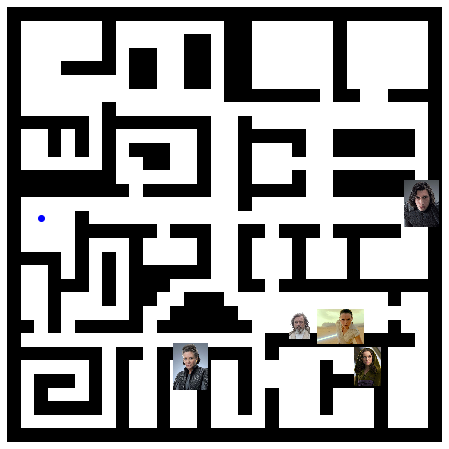

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def main(positions, image_paths):
    x = positions[:, 0]
    y = positions[:, 1]
    fig, ax = plt.subplots()
    ax.imshow(np.flipud(floorplan.T), extent=figure_bounds, cmap='Greys_r')          # images and matrixes are indexed differently. Use this to plot floorplan image.
    ax.scatter(position_robot[0], position_robot[1], c='b')
    imscatter(x, y, image_paths, zoom=0.05, ax=ax)
    ax.scatter(x, y, color='r')
    #plt.show()

def imscatter(x, y, images, ax=None, zoom=1):
    # display the relevent images at each (x, y) location
    if ax is None:
        ax = plt.gca()

    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, i0 in zip(x, y, images):
        try:
          img = plt.imread(i0)
        except TypeError:
          # Likely already an array...
          pass
        im = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


positions = position_customers
image_paths = []
for i in range(len(position_customers)):
  image_paths.append(os.path.join(f"customers/{i}", os.listdir(f"customers/{i}")[0]))
""" # example for reading image paths
image_paths = []
for i in range(len(position_customers)):
  image_paths.append(os.path.join(f"customers/{i}", os.listdir(f"customers/{i}")[0]))
"""

main(positions, image_paths)

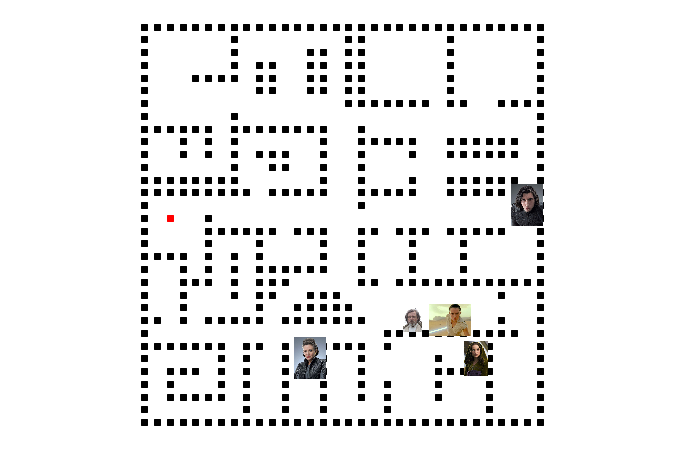

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# values
obstacles = np.asarray(np.where(floorplan == 0)).T
obs = set()
for i in range(len(obstacles)):
  obs.add((obstacles[i, 0], obstacles[i, 1]))
s_start = tuple(position_robot)
s_goal = tuple(position_customers[int(name)])
result = path
result = np.asarray(result)
# visited = # write code - list of visited nodes

# unanimated parts of plot
obs_x = [x[0] for x in obstacles]
obs_y = [x[1] for x in obstacles]
ax.plot(obs_x, obs_y, "sk")

ax.plot(s_start[0], s_start[1], "rs")
ax.plot(s_goal[0], s_goal[1], "bs")
plt.axis('equal')

# v_x = [x[0] for x in visited]
# v_y = [x[1] for x in visited]
# ax.scatter(v_x, v_y, color='grey')
imscatter(positions[:, 0], positions[:, 1], image_paths, zoom=0.045, ax=ax)
# line to animate
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)
    
def animate(i):
    # at time i, draw from 0th frame to ith frame 
    line.set_data(result[:i, 0], result[:i, 1])
    return (line,)

# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [ ]:
# display
anim

## save animation
#anim.save('animation.gif', writer='imagemagick', fps=60)

NameError: ignored